In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.losses import mean_squared_error
import glob
import matplotlib.patches as patches
import json
import numpy as np
from matplotlib.path import Path
import dicom
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/Users/attia/Desktop/Work/workenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


The first step of the algorithm is to locate the Left-Ventricle and compute the Regions of Interest (ROI) around it. We want to re-create the convolutional neural network for this automatic detection. This CNN will generate binary mask with the ROI.  
The first part is to open the dataset (pictures with the respective contour around the left ventricle) and generate the binary mask ROI (image with black background and a white foreground corresponding to the ROI) from the labeled data (contours drawn by experts), as it's the output of the CNN.
The second part is the CNN model and the training.

## Open dataset

In [2]:
def get_roi(image, contour, shape_out = 32):
    """
    Create a binary mask with ROI from contour. 
    Extract the maximum square around the contour.
    :param image: input image (needed for shape only)
    :param contour: numpy array contour (d, 2)
    :return: numpy array mask ROI (shape_out, shape_out)
    """
    X_min, Y_min = contour[:,0].min(), contour[:,1].min()
    X_max, Y_max = contour[:,0].max(), contour[:,1].max()  
    w = X_max - X_min
    h = Y_max - Y_min
    mask_roi = np.zeros(image.shape)
    if w > h :
        mask_roi[int(Y_min - (w -h)/2):int(Y_max + (w -h)/2), int(X_min):int(X_max)] = 1.0
    else :
        mask_roi[int(Y_min):int(Y_max), int(X_min - (h-w)/2):int(X_max + (h -w)/2)] = 1.0
    return cv2.resize(mask_roi, (shape_out, shape_out), interpolation = cv2.INTER_NEAREST)

In [12]:
X, X_fullsize, Y, contour_mask = create_dataset(n_set='train')

Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)


In [10]:
def create_dataset(image_shape=64, n_set='train', original_image_shape=256, 
                   roi_shape=32, data_path='./Data/'):
    """
    Creating the dataset from the images and the contour for the CNN.
    :param image_shape: image dataset desired size
    :param original_image_shape: original image size
    :param roi_shape: binary ROI mask shape
    :param data_path: path for the dataset
    :return: correct size image dataset, full size image dataset, label (contours) dataset
    """
    
    if n_set == 'train':
        number_set = 3
        name_set = 'Training'
    elif n_set == 'test':
        number_set = 1
        name_set = 'Online'         
    # Create dataset
    series = json.load(open('series_case.json'))[n_set]
    images, images_fullsize, contours, contour_mask = [], [], [], []
    # Loop over the series
    for case, serie in series.items():
        image_path_base = data_path + 'challenge_%s/%s/IM-%s' % (name_set.lower(),case, serie)
        contour_path_base = data_path + 'Sunnybrook Cardiac MR Database ContoursPart%s/\
%sDataContours/%s/contours-manual/IRCCI-expert/' % (number_set, name_set, case)
        contours_list = glob.glob(contour_path_base + '*')
        contours_list_series = [k.split('/')[7].split('-')[2] for k in contours_list]
        # Loop over the contours/images
        for c in contours_list_series:
            # Get contours and images path
            idx_contour = contours_list_series.index(c)
            image_path = image_path_base + '-%s.dcm' % c
            contour_path = contours_list[idx_contour]

            # open image as numpy array and resize to (image_shape, image_shape)
            image_part = dicom.read_file(image_path).pixel_array  

            # open contours as numpy array
            contour = []
            file = open(contour_path, 'r') 
            for line in file: 
                contour.append(tuple(map(float, line.split())))
            contour = np.array(contour)
            # append binary ROI mask 
            contours.append(get_roi(image_part, contour))

            # create mask contour with experts contours
            x, y = np.meshgrid(np.arange(256), np.arange(256)) # make a canvas with coordinates
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T 
            p = Path(contour) # make a polygon
            grid = p.contains_points(points)
            mask_contour = grid.reshape(256,256)
            mask_contour=mask_contour*1
            contour_mask.append(mask_contour)
            
            # Open image and resize it 
            images.append(cv2.resize(image_part, (image_shape, image_shape)))
            images_fullsize.append(cv2.resize(image_part, (original_image_shape, original_image_shape)))
    X_fullsize = np.array(images_fullsize)
    X = np.reshape(np.array(images), [len(images), image_shape, image_shape, 1])
    Y = np.reshape(np.array(contours), [len(contours), 1, roi_shape, roi_shape])
    print('Dataset shape :', X.shape, Y.shape)
    return X, X_fullsize, Y, contour_mask

For the input, the original image size of $256\times256$ has been downsampled to $64\times64$. The binary ROI mask (used as the labels) has a size of $32\times32$ (as the CNN output mask). The white foreground of the binary mask is centered at the center of the left ventricle contour (known from the training manual contours).

###### Note à modifier : 
Est ce qu'il faut shuffle (X,Y) avant le training ou le CNN le fait automatiquement ?

In [4]:
X, X_fullsize, Y, contour_mask = create_dataset()

Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)


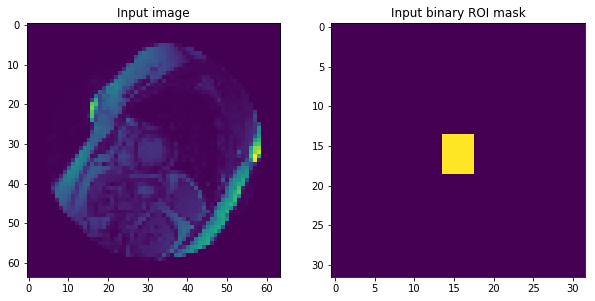

In [5]:
f, ax = plt.subplots(ncols = 2, figsize=(10,10))
ax[0].imshow(X[30].reshape(64,64))
ax[0].set_title('Input image')
ax[1].imshow(Y[30].reshape(32, 32))
_ = ax[1].set_title('Input binary ROI mask')

## Create model

### Model

In [6]:
def create_model(input_shape=(64, 64)):
    """
    Simple convnet model : one convolution, one average pooling and one fully connected layer:
    :return: Keras model
    """
    model = Sequential()
    model.add(Conv2D(100, (11,11), padding='valid', strides=(1, 1), input_shape=(input_shape[0], input_shape[1], 1)))
    model.add(AveragePooling2D((6,6)))
    model.add(Reshape([-1, 8100]))
    model.add(Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Reshape([-1, 32, 32]))
    return model

In [7]:
m = create_model()
m.compile(loss='mean_squared_error',
          optimizer='adam',
          metrics=['accuracy'])
print('Size for each layer :\nLayer, Input Size, Output Size')
for p in m.layers:
    print(p.name.title(), p.input_shape, p.output_shape)

Size for each layer :
Layer, Input Size, Output Size
Conv2D_1 (None, 64, 64, 1) (None, 54, 54, 100)
Average_Pooling2D_1 (None, 54, 54, 100) (None, 9, 9, 100)
Reshape_1 (None, 9, 9, 100) (None, 1, 8100)
Dense_1 (None, 1, 8100) (None, 1, 1024)
Reshape_2 (None, 1, 1024) (None, 1, 32, 32)


### Training

Training the CNN involves obtaining the optimum values of filters. In the paper, they are using a sparse autoencoder which acts a pre-training step because the number of training and labeled data is limited. The task of a autoencoder is to construct $x^{(i)}$ at the output from the hidden values. We didn't implement this sparse autoencoder. We can try data augmentation : the number of training and labeled data is limited so we can try to use data augmentation in order to generate new picture from our training set. With the Keras library, we can apply transformations on our training pictures to generate "new" pictures.

In [8]:
def training(m, X, Y, batch_size=16, epochs= 10, data_augm=False):
    """
    Training CNN with the possibility to use data augmentation
    :param m: Keras model
    :param X: training pictures
    :param Y: training binary ROI mask
    :return: history
    """
    if data_augm:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=50,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False) 
        datagen.fit(X)
        history = m.fit_generator(datagen.flow(X, Y,
                                    batch_size=batch_size),
                                    steps_per_epoch=X.shape[0] // batch_size,
                                    epochs=epochs)         
    else:
        history = m.fit(X, Y, batch_size=batch_size, epochs=epochs)
    return history

In [9]:
h = training(m, X, Y, batch_size=16, epochs= 20, data_augm=False)

Epoch 1/20
495/495 [==============================] - 5s 11ms/step - loss: 0.1845 - acc: 0.1955
Epoch 2/20
495/495 [==============================] - 5s 10ms/step - loss: 0.1044 - acc: 0.1415
Epoch 3/20
495/495 [==============================] - 5s 10ms/step - loss: 0.0782 - acc: 0.0820
Epoch 4/20
495/495 [==============================] - 6s 11ms/step - loss: 0.0632 - acc: 0.0460
Epoch 5/20
495/495 [==============================] - 5s 11ms/step - loss: 0.0539 - acc: 0.0403
Epoch 6/20
495/495 [==============================] - 6s 11ms/step - loss: 0.0480 - acc: 0.0490
Epoch 7/20
495/495 [==============================] - 5s 10ms/step - loss: 0.0425 - acc: 0.0562
Epoch 8/20
495/495 [==============================] - 5s 10ms/step - loss: 0.0394 - acc: 0.0598
Epoch 9/20
495/495 [==============================] - 5s 10ms/step - loss: 0.0374 - acc: 0.0674
Epoch 10/20
495/495 [==============================] - 5s 10ms/step - loss: 0.0353 - acc: 0.0506
Epoch 11/20
495/495 [==================

Text(0.5,1,'Learning curve')

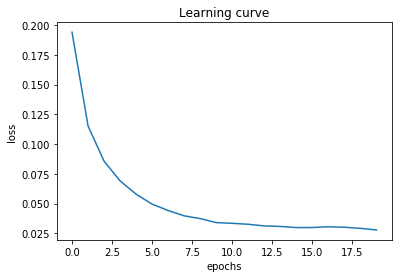

In [14]:
metric = 'loss'
plt.plot(range(len(h.history[metric])), h.history[metric])
plt.ylabel(metric)
plt.xlabel('epochs')
plt.title("Learning curve")

The original MR image size is $256\times256$. Therefore, the output mask is up-sampled from $32\times32$ to this original MR size. The center of the mask is then computed and used to crop a ROI of size $100\times100$ from the original image for further processing in the next stage (stacked AE).

### Predictions and computations for next stage

In [15]:
y_pred = m.predict(X, batch_size=16)
%store y_pred

Stored 'y_pred' (ndarray)


In [28]:
def compute_roi_pred(y_pred, idx, roi_shape=32):
    """
    Computing and cropping a ROI from the original image for further processing in the next stage
    :param y_pred: predictions
    :param idx: desired image prediction index
    :param roi_shape: shape of the binary mask
    """
    # up sampling from 32x32 to original MR size
    pred = cv2.resize(y_pred[idx].reshape((roi_shape, roi_shape)), (
                      256,256), cv2.INTER_NEAREST)
    # select the non null pixels
    pos_pred = np.array(np.where(pred > 0.5))
    # get the center of the mask
    X_min, Y_min = pos_pred[0, :].min(), pos_pred[1, :].min()
    X_max, Y_max = pos_pred[0, :].max(), pos_pred[1, :].max()  
    X_middle = X_min + (X_max - X_min) / 2
    Y_middle = Y_min + (Y_max - Y_min) / 2
    # Find ROI coordinates
    X_top = int(X_middle - 50)
    Y_top = int(Y_middle - 50)
    X_down = int(X_middle + 50)
    Y_down = int(Y_middle + 50)
    # crop ROI of size 100x100
    mask_roi = np.zeros((256, 256))
    mask_roi = cv2.rectangle(mask_roi, (X_top, Y_top), (X_down, Y_down), 1, -1)*255
    return X_fullsize[idx][X_top:X_down, Y_top:Y_down], mask_roi, contour_mask[idx][X_top:X_down, Y_top:Y_down]

In [29]:
pred2, mask_roi, mask_contour = compute_roi_pred(y_pred, 234)

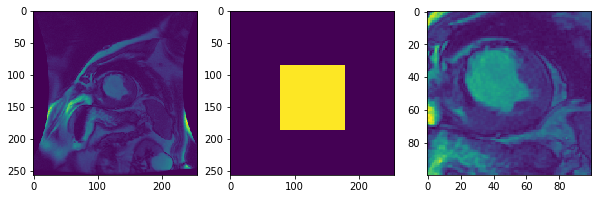

In [19]:
f, ax = plt.subplots(ncols=3, figsize=(10,10))
ax[0].imshow(X_fullsize[234])
ax[1].imshow(mask_roi)
ax[2].imshow(pred2)

In [19]:
cv2.imwrite('./Rapport/images/mask_roi.png', mask_roi)
cv2.imwrite('./Rapport/images/predic_roi.png', pred2)

True

(<matplotlib.image.AxesImage at 0x1251b86a0>, (100, 100))

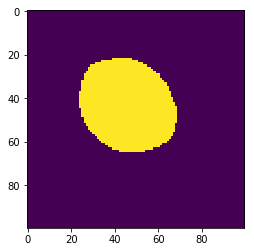

In [31]:
plt.imshow(mask_contour), mask_contour.shape